In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/NYC_Cab_Analysis/Datasets

/content/drive/MyDrive/NYC_Cab_Analysis/Datasets


### Sec 1: Imports and Load Dataset

I am considering FHV Jan 2018 dataset. It has data of 20 million FHV trips registered in Jan 2018. The data is taken from https://www.nyc.gov/site/tlc/about/fhv-trip-record-data.page

In [ ]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import plotly.express as px
import geopandas as gpd

In [ ]:
# Default column names
cols = [
  'dispatching_base_num',
  'pickup_datetime',
  'dropOff_datetime',
  'PUlocationID',
  'DOlocationID',
  'SR_Flag',
  'Affiliated_base_number'
]

# Default datatypes
dtypes = {
  'dispatching_base_num': str,
  'PUlocationID': np.float64,
  'DOlocationID': np.float64,
  'SR_Flag': np.float64,
  'Affiliated_base_number': str
}

# Parse as datetime objects
parse_dates = ['pickup_datetime', 'dropOff_datetime']

file_path = 'fhv_tripdata_2018-01.csv'
df = pd.read_csv(file_path, usecols=cols, dtype=dtypes)
df.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00001,2018-01-01 00:45:00,2018-01-01 01:05:55,NaN,NaN,NaN,B00001
1,B00001,2018-01-01 00:30:00,2018-01-01 01:30:28,NaN,NaN,NaN,B00001
2,B00001,2018-01-01 00:15:00,2018-01-01 00:41:26,NaN,NaN,NaN,B00001
3,B00001,2018-01-01 00:30:00,2018-01-01 01:57:09,NaN,NaN,NaN,B00001
4,B00008,2018-01-01 00:27:00,2018-01-01 00:58:00,NaN,NaN,NaN,B00008


### Sec 2: Data Cleaning and Memory Reduction

In [ ]:
# The head itself has NaN values. We will have to check for NaN.
# This is a custom statistic I use for getting a better insight on Null values of data
def get_custom_stats(df):
    result = pd.DataFrame({
      'num_of_unique': df.nunique(),
      'contains_null': df.isna().any(),
      'null_count': df.isnull().sum(),
      'null_pct': round((df.isnull().sum() / len(df)) * 100, 4),
      })
    return result

print(get_custom_stats(df))
print("Total Number of rows in final dataframe: ", len(df))

                        num_of_unique  contains_null  null_count  null_pct
dispatching_base_num              725          False           0    0.0000
pickup_datetime               2599675          False           0    0.0000
dropOff_datetime              2602508          False           0    0.0000
PUlocationID                      263           True     3569395   18.0199
DOlocationID                      265           True     1986916   10.0308
SR_Flag                            23           True    15483286   78.1665
Affiliated_base_number           1747           True      223735    1.1295
Total Number of rows in final dataframe:  19808094


Ideally, instead of dropping we should have used some method for imputation.

But here, we should simply drop the data for 2 primary reasons:
  1. We cannot make guesses on Pick-up and Drop-off locations. So we have no choice but to drop rows where this data is null
  2. Even after dropping all the rows with null data, we are still left with a significant number of data points for analysis.

In [ ]:
df = df.dropna(subset=['PUlocationID', 'DOlocationID', 'Affiliated_base_number'])

# Let us make SR_Flag as 0/1. 0 means the ride is individual, 1 indicates the ride is shared.
df['SR_Flag'] = df['SR_Flag'].fillna(0)
print(get_custom_stats(df))
print("Total Number of rows in final dataframe: ", len(df))

                        num_of_unique  contains_null  null_count  null_pct
dispatching_base_num              157          False           0       0.0
pickup_datetime               2559605          False           0       0.0
dropOff_datetime              2559490          False           0       0.0
PUlocationID                      263          False           0       0.0
DOlocationID                      265          False           0       0.0
SR_Flag                            24          False           0       0.0
Affiliated_base_number           1437          False           0       0.0
Total Number of rows in final dataframe:  16004993


In [ ]:
# For basic memory reduction, let's try to have a look at data types
df.dtypes

dispatching_base_num       object
pickup_datetime            object
dropOff_datetime           object
PUlocationID              float64
DOlocationID              float64
SR_Flag                   float64
Affiliated_base_number     object
dtype: object

In [ ]:
print(df.memory_usage(deep=True))
# Total memory usage of the Initial clean DataFrame
total_memory_usage = df.memory_usage(deep=True).sum() / (1024 * 1024)
print(f"Total memory usage: {total_memory_usage:.2f} MB")


Index                      128039944
dispatching_base_num      1008738117
pickup_datetime           1216379468
dropOff_datetime          1216379468
PUlocationID               128039944
DOlocationID               128039944
SR_Flag                    128039944
Affiliated_base_number    1008815452
dtype: int64
Total memory usage: 4732.58 MB


In [ ]:
# Memory Reduction

# For identifying usage paterns, we do not need Affiliated_base_number.
df.drop('Affiliated_base_number', axis=1, inplace=True)

# SR_Flag contains only 0/1 values
df['SR_Flag'] = df['SR_Flag'].astype(bool)

# Changing to date-time objects
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropOff_datetime'] = pd.to_datetime(df['dropOff_datetime'])

# Convert to int16 from float64 if it is safe with 0 data loss
def can_convert_to_int16(column):
    if pd.isnull(column).any():
        return False

    if (column == column.astype(int)).all() and column.min() >= np.iinfo(np.int16).min and column.max() <= np.iinfo(np.int16).max:
        return True
    return False

columns_to_check = ['PUlocationID', 'DOlocationID']

# Convert columns
for col in columns_to_check:
    if can_convert_to_int16(df[col]):
        df[col] = df[col].astype(np.int16)
        print(f"Converted {col} to int16")
    else:
        print(f"Did not convert {col} - not safe to convert to int16")

print(df.dtypes)

Converted PUlocationID to int16
Converted DOlocationID to int16
dispatching_base_num            object
pickup_datetime         datetime64[ns]
dropOff_datetime        datetime64[ns]
PUlocationID                     int16
DOlocationID                     int16
SR_Flag                           bool
dtype: object


In [ ]:
total_memory_usage_reduced = df.memory_usage(deep=True).sum() / (1024 * 1024)

# Let us see if we could reduce the memory.
total_reduction = total_memory_usage - total_memory_usage_reduced
percentage_reduction = (total_reduction / total_memory_usage) * 100

print(f"Total Memory Usage Before Reduction: {total_memory_usage:.2f} MB")
print(f"Total Memory Usage After Reduction: {total_memory_usage_reduced:.2f} MB")
print(f"Total Reduction: {total_reduction:.2f} MB")
print(f"Percentage Reduction with 0 data loss: {percentage_reduction:.2f}%")

Total Memory Usage Before Reduction: 4732.58 MB
Total Memory Usage After Reduction: 1404.65 MB
Total Reduction: 3327.93 MB
Percentage Reduction with 0 data loss: 70.32%


In [ ]:
# New final data types
df.dtypes

dispatching_base_num            object
pickup_datetime         datetime64[ns]
dropOff_datetime        datetime64[ns]
PUlocationID                     int16
DOlocationID                     int16
SR_Flag                           bool
dtype: object

#### Conclusion: We have reduced the dataset size by almost 3.3 GB / 70% just by representing the data using correct data types

### Sec 3: Pinpoint primary hot zones for FHV pick-ups and drop-offs.


In [ ]:
# Taxi Zone lookup table which maps IDs to Zones
lookup = pd.read_csv('taxi-zone-lookup.csv')

In [ ]:
id_to_zone = dict(zip(lookup.LocationID, lookup.Zone))

top_20_pickup = df['PUlocationID'].value_counts().nlargest(20)
top_20_dropoff = df['DOlocationID'].value_counts().nlargest(20)

top_20_pickup_zones = top_20_pickup.index.map(id_to_zone.get).tolist()
top_20_dropoff_zones = top_20_dropoff.index.map(id_to_zone.get).tolist()

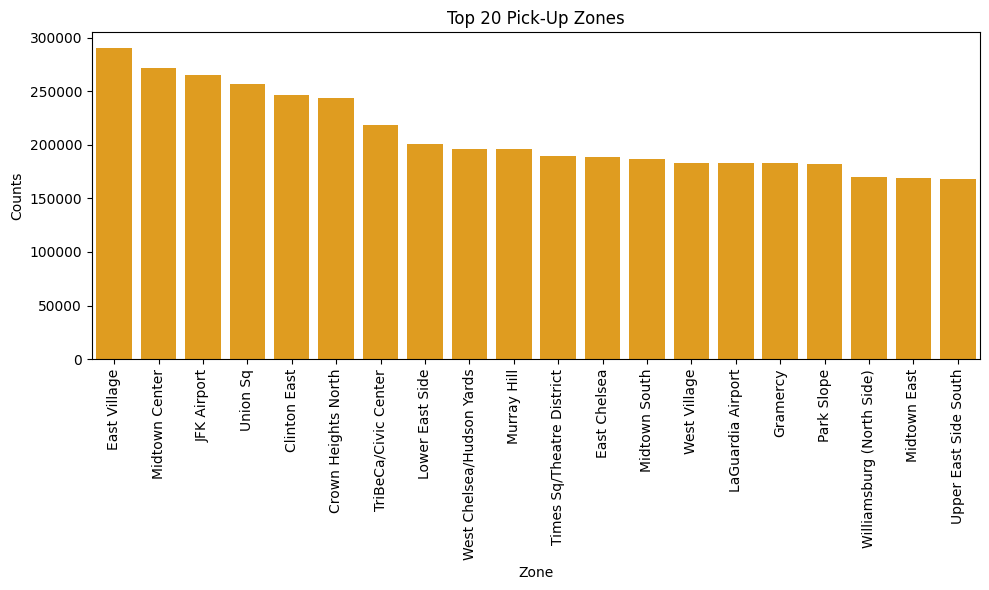

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=top_20_pickup_zones, y=top_20_pickup.values, color = "orange")
plt.title('Top 20 Pick-Up Zones')
plt.xlabel('Zone')
plt.ylabel('Counts')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

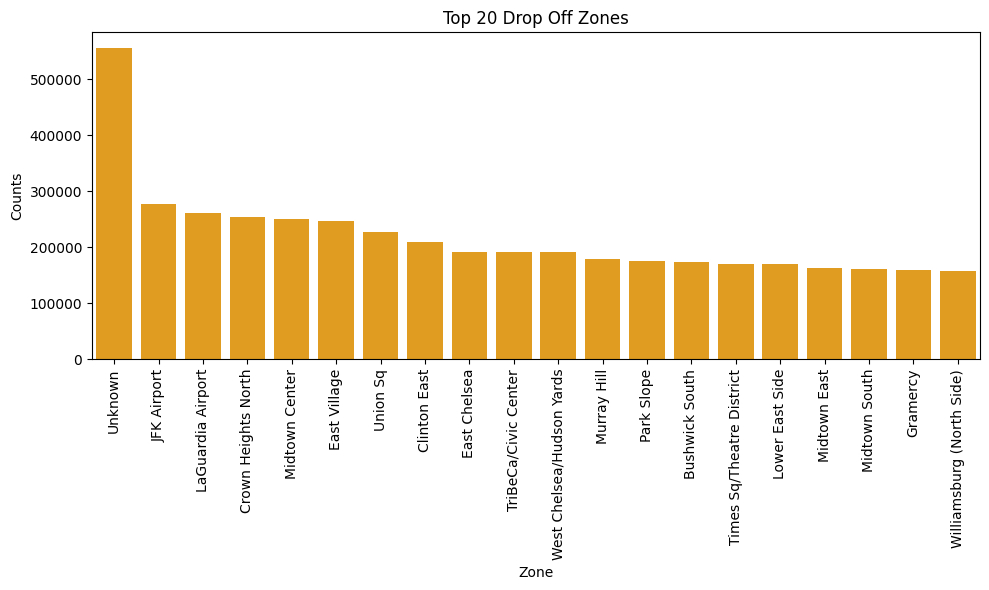

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=top_20_dropoff_zones, y=top_20_dropoff.values, color = "orange")
plt.title('Top 20 Drop Off Zones')
plt.xlabel('Zone')
plt.ylabel('Counts')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

At first, I thought the Unknown taxi location (256) is due to missing or incorrect data.
<br>But 2 main points are to be noted:

1. The data with Id 256 (Unknown) is only in dropoffs and not pickups.
2. There are more than 500k rows with drop off id 256.



This is an artifact and not data error.

**The ID 256 is due to Ride cancellation / Ending the trip midway before completion.** So we can conclude, 500k trips were ended mid-way and thus, they do not record drop location for that trip.

In [ ]:
# I can see most of the locations are common in top pickups and drop offs
# We can verify that using set intersection

print('Locations that are present in pick ups but not in drop offs: ', set(top_20_dropoff_zones).difference(set(top_20_pickup_zones)))
print('Locations that are present in drop offs but not in pick ups: ', set(top_20_pickup_zones).difference(set(top_20_dropoff_zones)))

Locations that are present in pick ups but not in drop offs:  {'Unknown', 'Bushwick South'}
Locations that are present in drop offs but not in pick ups:  {'Upper East Side South', 'West Village'}


Let us try to find areas that have predominantly high pickups and low drop offs, and vice verca.

In [ ]:
# Finding areas where the difference between pick ups and drop offs is maximum

# Data preparation
id_to_zone = dict(zip(lookup['LocationID'], lookup['Zone']))
total_dropoffs = df['DOlocationID'].value_counts()
total_pickups = df['PUlocationID'].value_counts()

df_dropoffs = total_dropoffs.reset_index()
df_dropoffs.columns = ['LocationID', 'DropOffCount']

df_pickups = total_pickups.reset_index()
df_pickups.columns = ['LocationID', 'PickUpCount']

merged_df = pd.merge(df_dropoffs, df_pickups, on='LocationID', how='outer')
merged_df.fillna(0, inplace=True)

merged_df['DropOff_PickUp_Diff'] = merged_df['DropOffCount'] - merged_df['PickUpCount']
merged_df['PickUp_DropOff_Diff'] = merged_df['PickUpCount'] - merged_df['DropOffCount']
merged_df['Zone'] = merged_df['LocationID'].map(id_to_zone)
merged_df = merged_df[merged_df['LocationID'] != 265]

top_20_dropoff_high = merged_df.sort_values(by='DropOff_PickUp_Diff', ascending=False).head(20)
top_20_pickup_high = merged_df.sort_values(by='PickUp_DropOff_Diff', ascending=False).head(20)

top_20_dropoff_high = top_20_dropoff_high.sort_values(by='DropOff_PickUp_Diff', ascending=False)
top_20_pickup_high = top_20_pickup_high.sort_values(by='PickUp_DropOff_Diff', ascending=False)

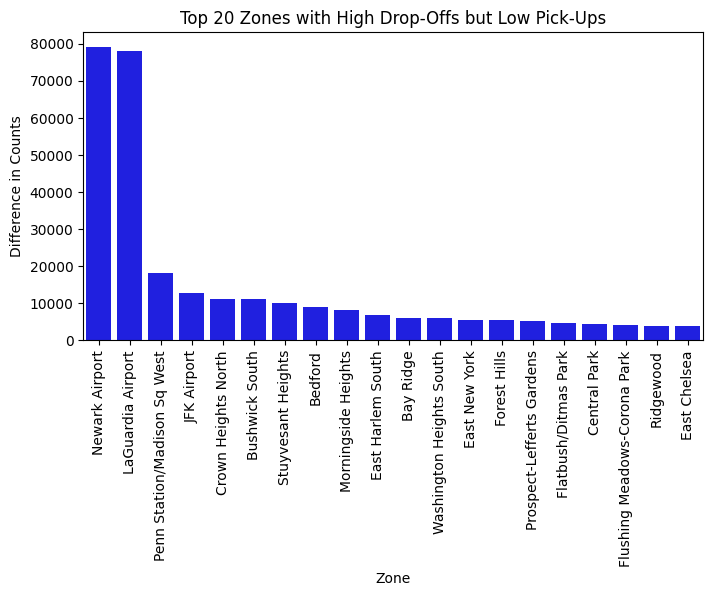

In [ ]:
# Plotting Difference between Drop offs and Pick ups
plt.figure(figsize=(8, 4))
sns.barplot(x='Zone', y='DropOff_PickUp_Diff', data=top_20_dropoff_high, color='blue')
plt.xticks(rotation=90)
plt.title('Top 20 Zones with High Drop-Offs but Low Pick-Ups')
plt.xlabel('Zone')
plt.ylabel('Difference in Counts')
plt.show()

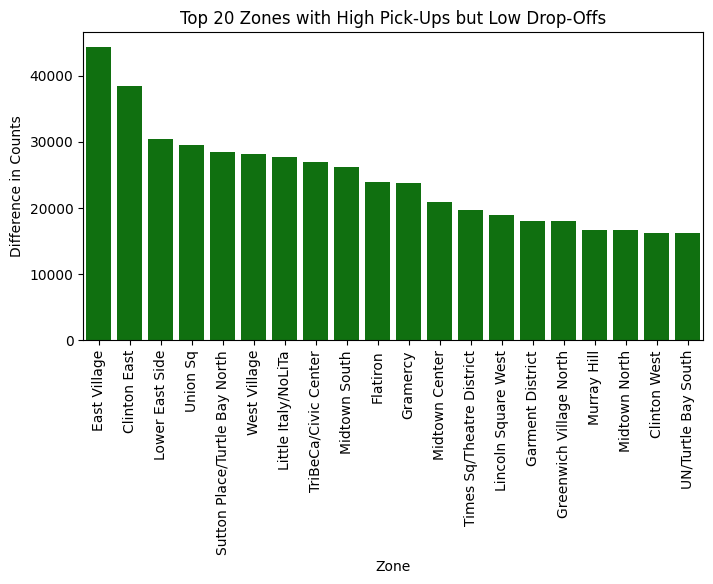

In [ ]:
# Plotting Difference between Pick ups and Drop offs
plt.figure(figsize=(8, 4))
sns.barplot(x='Zone', y='PickUp_DropOff_Diff', data=top_20_pickup_high, color='green')
plt.xticks(rotation=90)
plt.title('Top 20 Zones with High Pick-Ups but Low Drop-Offs')
plt.xlabel('Zone')
plt.ylabel('Difference in Counts')
plt.show()

Conclusion from the above 2 graphs:

1. High absolute pickups areas are maximum **residential** and **commercial** areas, probably in Manhattan. People using cabs for normal comute and going to work might result in this.
2. Airports show irreasonably high drop offs but low pick ups. On research, I came to know this was a very important issue. I have discussed this in detail in the report.

In short, many project managers have worked on this issue and the major result is due to following points:


1. High waiting time --> So drivers tend to not accept rides from airport. That issue is not in dropping them off
2. A passenger point of view --> Reliability is the key of FHVs. Passengers tend to use FHVs when the go to airport for arriving there on time. But when they return, they have multiple options and time to chose from.



### Sec 4: Visualizing on New York City (NYC) map

In [ ]:
# Reading the shape file which maps zones to Polygons
shapefile_path = 'NYC Taxi Zones/geo_export_71642482-5b5a-44fd-bec4-16c88442f6c1.shp'
taxi_zones_gdf = gpd.read_file(shapefile_path)

In [ ]:
# Preparing data for delta pick-ups and delta drop-offs to visualize on map

pickup_counts = df.groupby(['PUlocationID']).size().reset_index(name='pickup_count')
dropoff_counts = df.groupby(['DOlocationID']).size().reset_index(name='dropoff_count')

location_diff = pd.merge(pickup_counts, dropoff_counts, left_on='PUlocationID', right_on='DOlocationID', how='outer')
location_diff.fillna(0, inplace=True)

location_diff['pickup_dropoff_diff'] = location_diff['pickup_count'] - location_diff['dropoff_count']
location_diff['dropoff_pickup_diff'] = location_diff['dropoff_count'] - location_diff['pickup_count']

top_20_locations_pu = location_diff.sort_values(by='pickup_dropoff_diff', ascending=False).head(20)
top_20_locations_do = location_diff.sort_values(by='dropoff_pickup_diff', ascending=False).head(20)

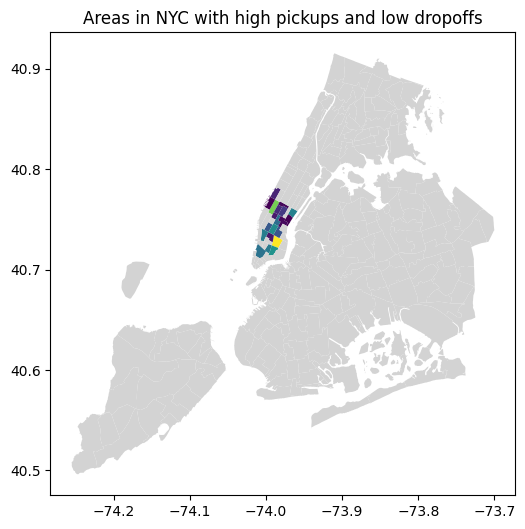

In [ ]:
# Plotting Areas in NYC with high pickups and low dropoffs
taxi_zones_gdf_1 = taxi_zones_gdf.merge(top_20_locations_pu, how='left', left_on='location_i', right_on='PUlocationID')

fig, ax = plt.subplots(1, 1, figsize=(6, 12))
taxi_zones_gdf_1.plot(column='pickup_dropoff_diff', ax=ax, cmap='viridis', missing_kwds={'color': 'lightgrey'})
plt.title("Areas in NYC with high pickups and low dropoffs")
plt.show()

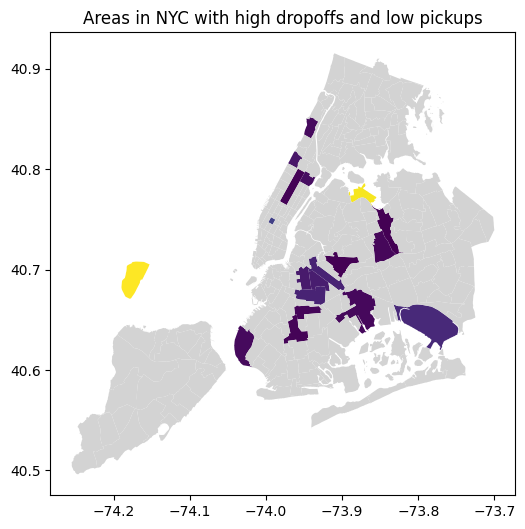

In [ ]:
# Plotting Areas in NYC with high dropoffs and low pickups

taxi_zones_gdf_2 = taxi_zones_gdf.merge(top_20_locations_do, how='left', left_on='location_i', right_on='DOlocationID')
fig, ax = plt.subplots(1, 1, figsize=(6, 12))
taxi_zones_gdf_2.plot(column='dropoff_pickup_diff', ax=ax, cmap='viridis', missing_kwds={'color': 'lightgrey'})
plt.title("Areas in NYC with high dropoffs and low pickups")
plt.show()

Now it is very clearly visible.
<br> The high pick up area is completely Manhatttan !
<br> The high drop off zone is Airports and Brooklyn

On researching about Brooklyn, there is a very good reason behind this! Green Cabs!
<br> **Green cabs are very heavily used in Brooklyn, which is resulting in low pickups for HFVs in Brooklyn.** They can pick up passengers only from Bronx, Staten Island and Brooklyn. This was a new vital piece of information.

#### Sec 5: Trends in Length, Time of trips

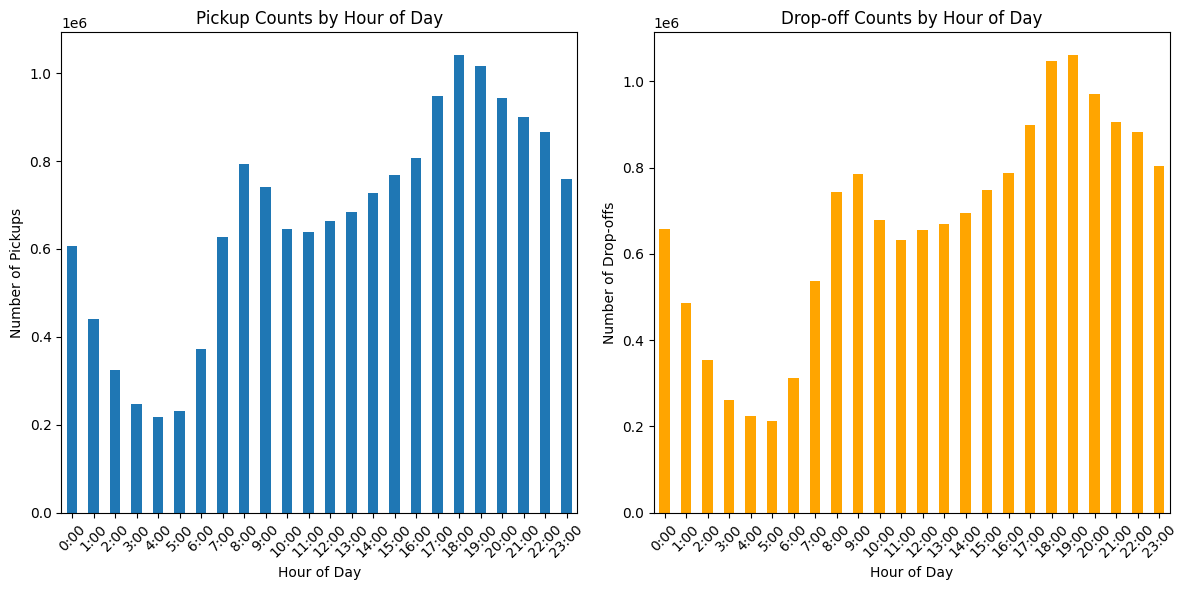

In [ ]:
# Plotting the number of trips as per time.
# Let us analyze if the number of trips increase during office hours.

df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropOff_datetime'] = pd.to_datetime(df['dropOff_datetime'])

df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['dropoff_hour'] = df['dropOff_datetime'].dt.hour
pickup_counts_by_hour = df.groupby('pickup_hour').size()
dropoff_counts_by_hour = df.groupby('dropoff_hour').size()

plt.figure(figsize=(12, 6))

# Plot for pickups
plt.subplot(1, 2, 1)
pickup_counts_by_hour.plot(kind='bar')
plt.xticks(range(0, 24), [f'{hour}:00' for hour in range(24)], rotation=45)
plt.xlabel('Hour of Day')
plt.ylabel('Number of Pickups')
plt.title('Pickup Counts by Hour of Day')

# Plot for drop-offs
plt.subplot(1, 2, 2)
dropoff_counts_by_hour.plot(kind='bar', color='orange')
plt.xticks(range(0, 24), [f'{hour}:00' for hour in range(24)], rotation=45)
plt.xlabel('Hour of Day')
plt.ylabel('Number of Drop-offs')
plt.title('Drop-off Counts by Hour of Day')

plt.tight_layout()
plt.show()


Considering a normal 9:00 to 5:00 job, if our hyppothesis is true and people actually do take an uber to work, we should see a peak in trips just before 9:00 and just after 5:00.
<br> Conclusions from the graph:


1.   We see two local maximums as expected. The local maxima at 8:00 AM in pickups and 9:00 AM in drop offs definitely indicate people commuting to work.
2.   Similarly, the local maxima at 6:00 PM and 7:00 PM show people taking a cab back to home.
2.   We see reduced number of cabs from 2:00 AM to 6:00 AM which is definitely expected.



#### Sec 6: Trends in Days of the week

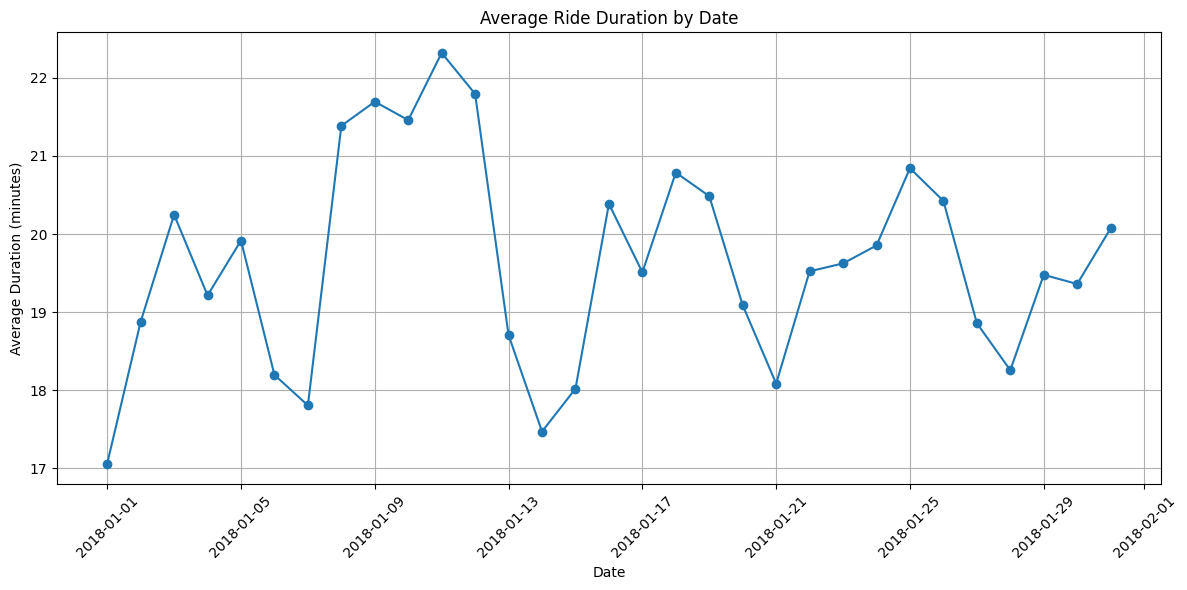

In [ ]:
# First let us plot for each day of the month in our data
df['date'] = df['pickup_datetime'].dt.date

# Group by date and calculate average ride duration
df['ride_duration'] = (df['dropOff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60
average_duration_by_date = df.groupby('date')['ride_duration'].mean()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(average_duration_by_date.index, average_duration_by_date.values, marker='o', linestyle='-')
plt.title('Average Ride Duration by Date')
plt.xlabel('Date')
plt.ylabel('Average Duration (minutes)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

We can see the local minima repeating after 7 days. Overall there is a repeating trend in average trip duration. Let us plot it for days of the week to verify if our observation is correct

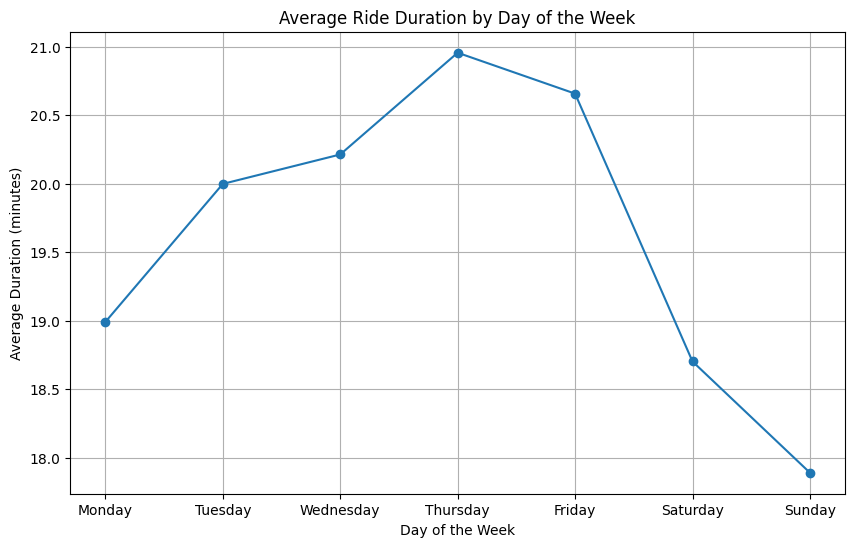

In [ ]:
# For days of the week
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
average_duration_by_day = df.groupby('day_of_week')['ride_duration'].mean()

plt.figure(figsize=(10, 6))
plt.plot(average_duration_by_day.index, average_duration_by_day.values, marker='o')

plt.title('Average Ride Duration by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Duration (minutes)')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.grid(True)
plt.show()

We can clearly see both the weekends (Saturday and Sunday) have lower trip duration than week days. As comapred to Thursdays (day with highest trip duration) Sundays have approximately 25% shorter duration trips.

In [ ]:
print('a')

a


In [ ]:
filtered_df = df[(df['PUlocationID'] != 265) & (df['DOlocationID'] != 265) & (df['PUlocationID'] != df['DOlocationID'])]
route_counts = filtered_df.groupby(['PUlocationID', 'DOlocationID']).size().reset_index(name='counts')
top_routes = route_counts.sort_values(by='counts', ascending=False).head(25)

In [ ]:
taxi_zones_gdf['centroid'] = taxi_zones_gdf.geometry.centroid
taxi_zones_gdf['centroid'] = taxi_zones_gdf['centroid'].to_crs(epsg=4326)
taxi_zones_gdf['latitude'] = taxi_zones_gdf['centroid'].y
taxi_zones_gdf['longitude'] = taxi_zones_gdf['centroid'].x

<ipython-input-29-5cae63548d4f>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  taxi_zones_gdf['centroid'] = taxi_zones_gdf.geometry.centroid


In [ ]:
def get_coordinates(location_id, gdf):
    location_data = gdf[gdf['location_i'] == location_id]
    if not location_data.empty:
        return (location_data.iloc[0]['latitude'], location_data.iloc[0]['longitude'])
    else:
        return (None, None)

In [ ]:
import folium
m = folium.Map(location=[40.7128, -74.0060], zoom_start=12)
for _, row in top_routes.iterrows():
    pickup_coords = get_coordinates(row['PUlocationID'], taxi_zones_gdf)
    dropoff_coords = get_coordinates(row['DOlocationID'], taxi_zones_gdf)
    folium.PolyLine([pickup_coords, dropoff_coords], color='blue', weight=2.5, opacity=1).add_to(m)

m


In [ ]:
# Rename the column in lookup DataFrame for clarity
lookup = lookup.rename(columns={'LocationID': 'location_id', 'Zone': 'zone'})

# Merge to get the pickup zone names
top_routes = route_counts.sort_values(by='counts', ascending=False).head(30)
top_routes = pd.merge(top_routes, lookup[['location_id', 'zone']], left_on='PUlocationID', right_on='location_id')
top_routes.rename(columns={'zone': 'pick_up_zone'}, inplace=True)
top_routes.drop('location_id', axis=1, inplace=True)

# Merge to get the drop-off zone names
top_routes = pd.merge(top_routes, lookup[['location_id', 'zone']], left_on='DOlocationID', right_on='location_id')
top_routes.rename(columns={'zone': 'drop_off_zone'}, inplace=True)
top_routes.drop('location_id', axis=1, inplace=True)
top_routes = top_routes.sort_values(by='counts', ascending=False)
# Display the updated DataFrame
top_routes


,PUlocationID,DOlocationID,counts,pick_up_zone,drop_off_zone
0,36,37,15213,Bushwick North,Bushwick South
1,37,36,14149,Bushwick South,Bushwick North
5,7,223,13703,Astoria,Steinway
6,112,255,13390,Greenpoint,Williamsburg (North Side)
9,188,61,13086,Prospect-Lefferts Gardens,Crown Heights North
14,223,7,13085,Steinway,Astoria
15,255,112,13001,Williamsburg (North Side),Greenpoint
10,225,61,12990,Stuyvesant Heights,Crown Heights North
3,61,225,12931,Crown Heights North,Stuyvesant Heights
20,61,188,12738,Crown Heights North,Prospect-Lefferts Gardens


In [ ]:
# Define airport location IDs
airport_ids = [1, 132, 138]
df['starts_at_airport'] = df['PUlocationID'].isin(airport_ids)
average_durations = df.groupby('starts_at_airport')['ride_duration'].mean()

# Display the results
print(average_durations)

starts_at_airport
False    18.969830
True     41.075227
Name: ride_duration, dtype: float64


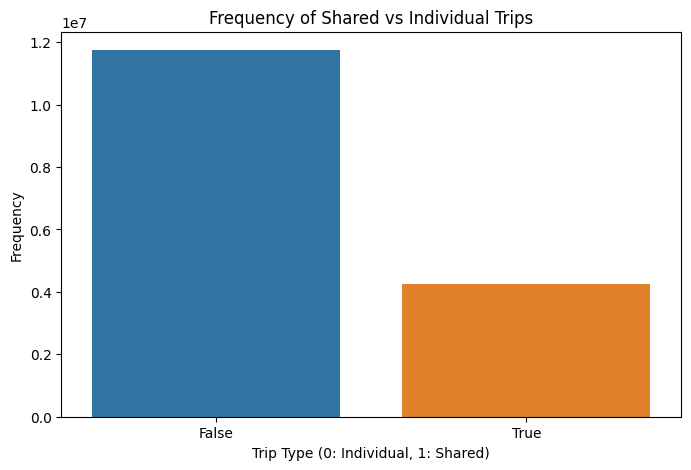

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Frequency analysis
shared_vs_individual_freq = df['SR_Flag'].value_counts()

# Plotting the frequency
plt.figure(figsize=(8, 5))
sns.barplot(x=shared_vs_individual_freq.index, y=shared_vs_individual_freq.values)
plt.title('Frequency of Shared vs Individual Trips')
plt.xlabel('Trip Type (0: Individual, 1: Shared)')
plt.ylabel('Frequency')
plt.show()

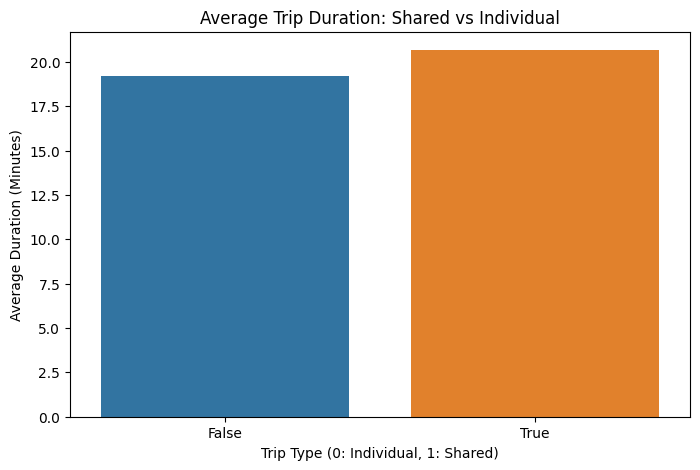

In [ ]:
# Duration analysis
average_durations = df.groupby('SR_Flag')['ride_duration'].mean()

# Plotting the duration
plt.figure(figsize=(8, 5))
sns.barplot(x=average_durations.index, y=average_durations.values)
plt.title('Average Trip Duration: Shared vs Individual')
plt.xlabel('Trip Type (0: Individual, 1: Shared)')
plt.ylabel('Average Duration (Minutes)')
plt.show()

<ipython-input-39-2ee07867a1f5>:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='pickup_hour', y='ride_duration', hue='SR_Flag', data=df, ci=None)


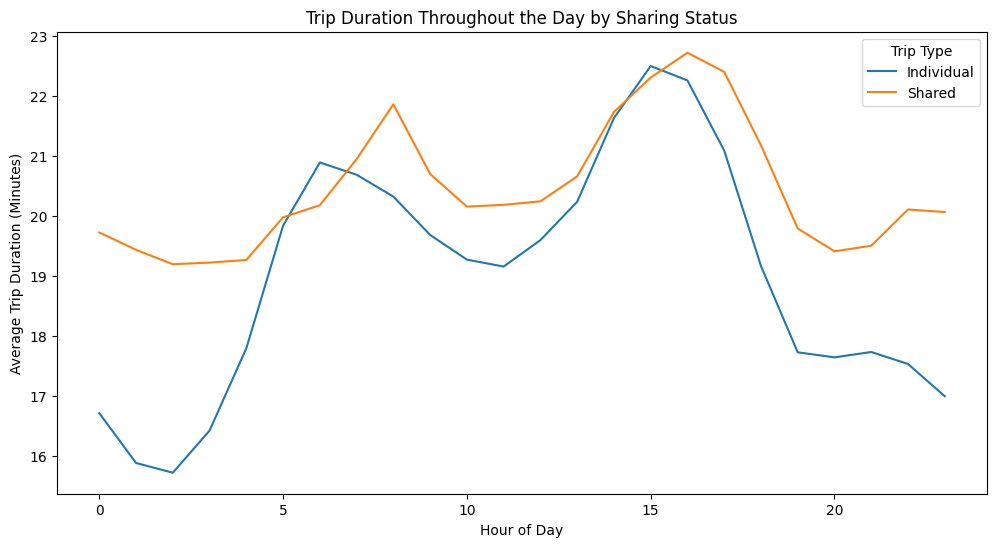

In [ ]:
# Extract hour from pickup_datetime
df['pickup_hour'] = df['pickup_datetime'].dt.hour

# Plotting distribution of trip durations over the day
plt.figure(figsize=(12, 6))
sns.lineplot(x='pickup_hour', y='ride_duration', hue='SR_Flag', data=df, ci=None)
plt.title('Trip Duration Throughout the Day by Sharing Status')
plt.xlabel('Hour of Day')
plt.ylabel('Average Trip Duration (Minutes)')
plt.legend(title='Trip Type', labels=['Individual', 'Shared'])
plt.show()


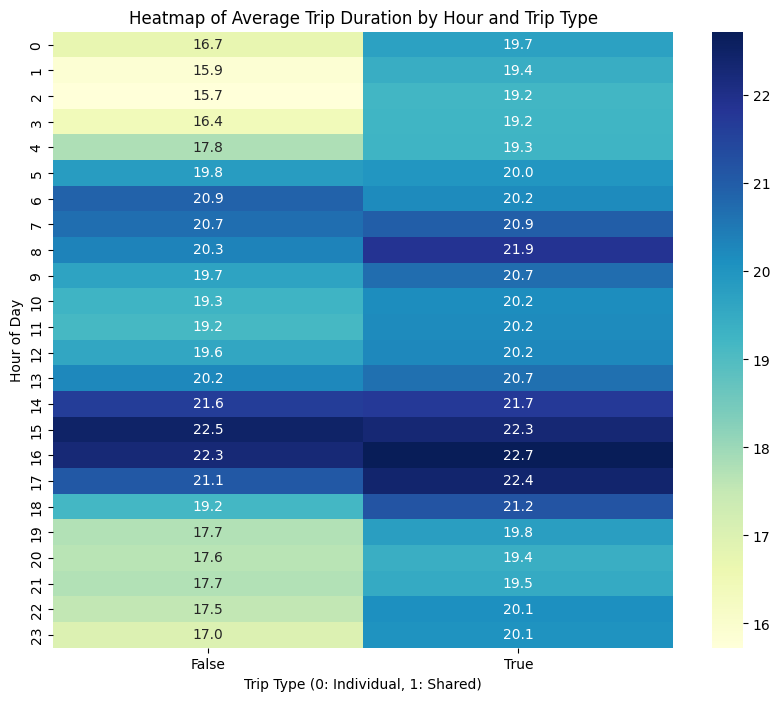

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Creating a pivot table for the heatmap
pivot_table = pd.pivot_table(df, values='ride_duration', index='pickup_hour', columns='SR_Flag', aggfunc=np.mean)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('Heatmap of Average Trip Duration by Hour and Trip Type')
plt.xlabel('Trip Type (0: Individual, 1: Shared)')
plt.ylabel('Hour of Day')
plt.show()


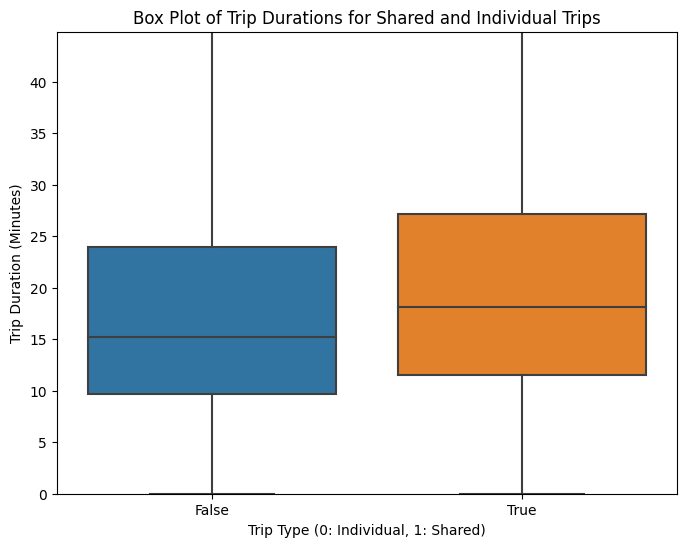

In [ ]:
# Box plot for trip durations
plt.figure(figsize=(8, 6))
sns.boxplot(x='SR_Flag', y='ride_duration', data=df)
plt.title('Box Plot of Trip Durations for Shared and Individual Trips')
plt.xlabel('Trip Type (0: Individual, 1: Shared)')
plt.ylabel('Trip Duration (Minutes)')
plt.ylim(0, df['ride_duration'].quantile(0.95))  # Limiting to 95th percentile
plt.show()


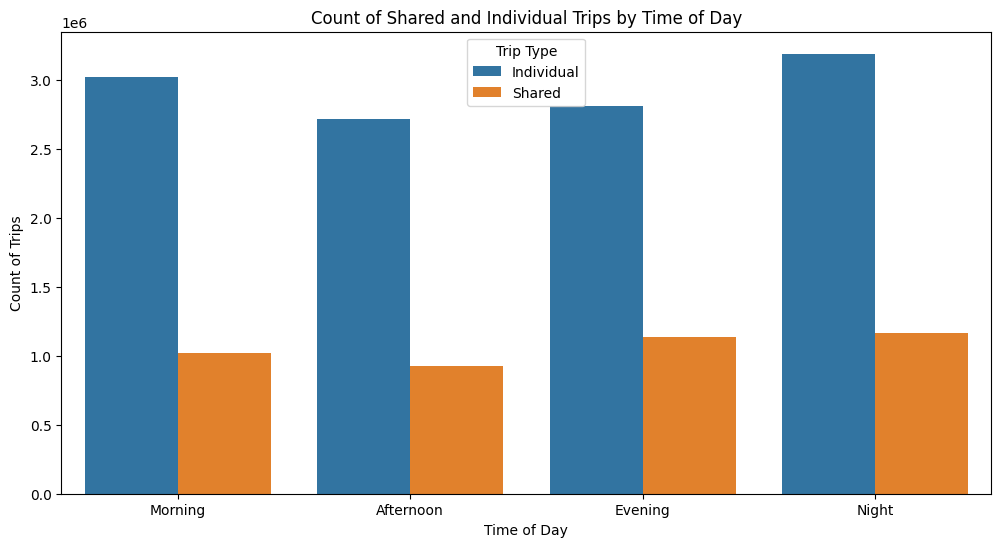

In [ ]:
# Define time segments
def time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['time_segment'] = df['pickup_hour'].apply(time_of_day)

# Count plot with time segmentation
plt.figure(figsize=(12, 6))
sns.countplot(x='time_segment', hue='SR_Flag', data=df, order=['Morning', 'Afternoon', 'Evening', 'Night'])
plt.title('Count of Shared and Individual Trips by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Count of Trips')
plt.legend(title='Trip Type', labels=['Individual', 'Shared'])
plt.show()


In [ ]:
# End of Report